In [1]:
import pathlib
import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns

%matplotlib inline
from matplotlib import pyplot as plt

sns.set_style("ticks")

savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.2,
    "transparent": True,
}

mpl.rc("savefig", dpi=300)
output_dir = "/home/michaelswift/repos/tabula-bursa/analysis/figures/"

pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

# Define the subtype output directory and make sure it exists
subtypes = "../../../data/annotation"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
sc.settings.figdir = output_dir
output_suffix = ""
output_formats = [".png", ".svg", ".pdf"]

def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%run ../helper.py

## Load the Data

In [2]:
celltype_file = "bcells"
celltypes = ['Memory B cells', "Plasma cells", "Plasmablasts"]

In [3]:
adata = sc.read_h5ad(
    f"../../../data/{celltype_file}.h5ad.gz", backed = 'r+'
)

In [4]:
#  filter non-B cells or doublets and things without antibody sequences
adata = adata[(adata.obs.c_call != 'nan') & (adata.obs.probable_hq_single_b_cell == "True")]
adata = adata.to_memory()

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/michaelswift/miniconda3/envs/scanpy_new/li

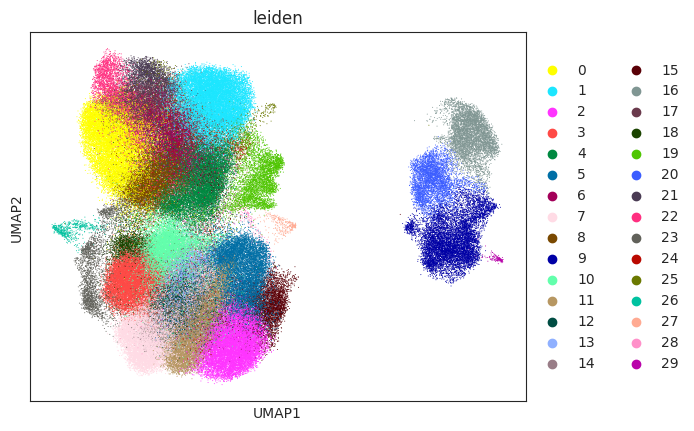

In [5]:
downsample = False
if downsample:  
    n = adata.obs.tissue.value_counts().min()
    resampled = adata[adata.obs.groupby('tissue').sample(n=down_sampled, replace=False).index]
    sc.pp.neighbors(resampled, use_rep="X_scVI_all", n_neighbors=40)
    sc.tl.umap(
        resampled,
    )
    sc.tl.leiden(resampled, resolution = 2)
    sc.pl.umap(resampled, color = 'leiden', size = 2)
    sc.pl.umap(resampled, size = 60, color = 'celltypist', alpha = 0.9, frameon=False, palette=bcelltype_colors_full)
    adata = resampled
else:
    sc.pp.neighbors(adata, use_rep="X_scVI_all", n_neighbors=40)
    sc.tl.umap(
        adata,
    )
    sc.tl.leiden(adata, resolution = 2)
    sc.pl.umap(adata, color = 'leiden', size = 2)

In [6]:
# create a unique lineage id (only unique within donor right now)
adata.obs['lineage_uid'] = adata.obs.lineage_id.astype(str) + "_" + adata.obs.donor.astype(str)
# define large lineages
lineage_size = 3
large_lineages = adata.obs.groupby(['lineage_uid']).size() > lineage_size
large_lineages = large_lineages[large_lineages].index
# identify large lineages that are majority naive  
naive_lineages = []
for lin in large_lineages:
    df = adata.obs[adata.obs.lineage_uid == lin]
    #print("lineage:", lin)
    #print('celltypist Labels')
    proportion = df.Immune_All_Low_predicted_labels.value_counts(normalize=True)[:]
    #print(proportion.loc['Naive B cells'])
    #print("\n\n")
    if proportion.loc['Naive B cells'] > 0.5:
        naive_lineages.append(lin)
print(len(naive_lineages) / len(large_lineages), "fraction of large lineages which are more than 1/2 naive")

0.24044265593561368 fraction of large lineages which are more than 1/2 naive


In [7]:
# define large naive lineage boolean as string so I can plot
adata.obs.loc[:,'in_lin'] = adata.obs.lineage_uid.isin(naive_lineages).astype(str)
# filter out celltypes
adata = adata[~adata.obs.celltypist.isin(celltypes)]
# define hypermutated category
adata.obs['hypermutated'] = adata.obs.v_mismatch > 2
adata.obs.hypermutated = adata.obs.hypermutated.astype('category')

/tmp/ipykernel_40589/1210802457.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['hypermutated'] = adata.obs.v_mismatch > 2


In [8]:
adata = adata[adata.obs.celltypist == "Naive B cells"]

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


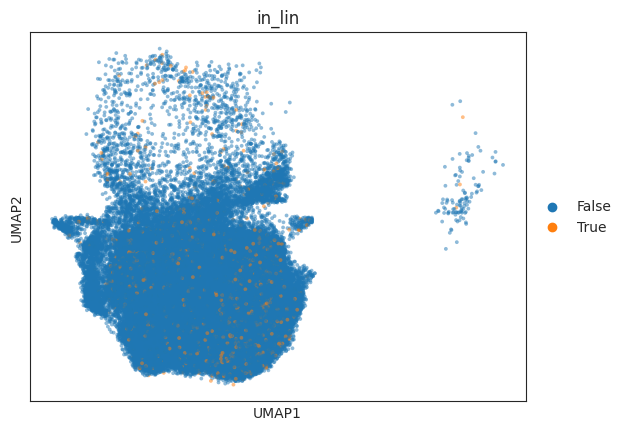

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


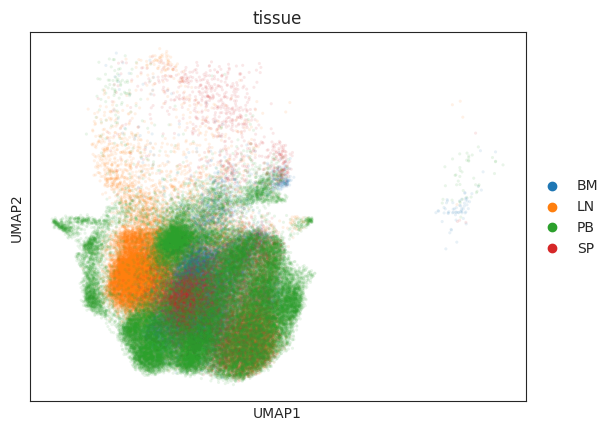

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


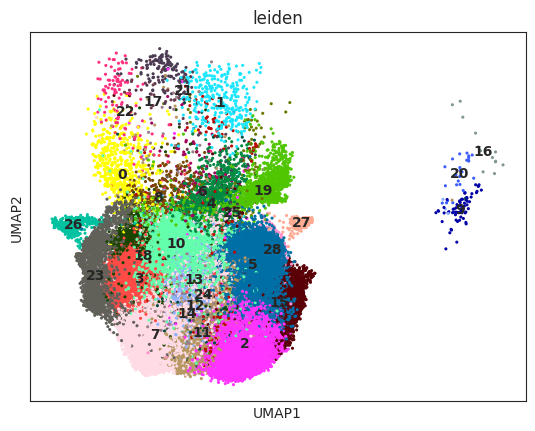

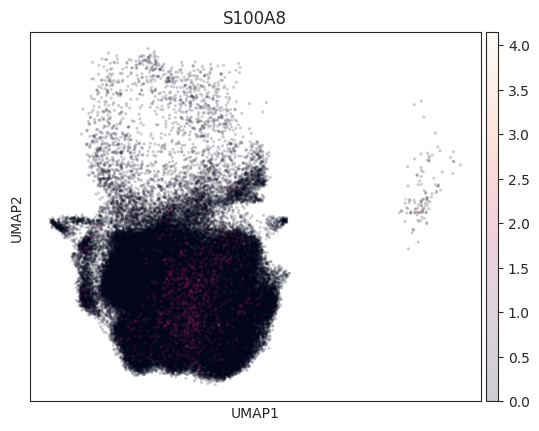

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


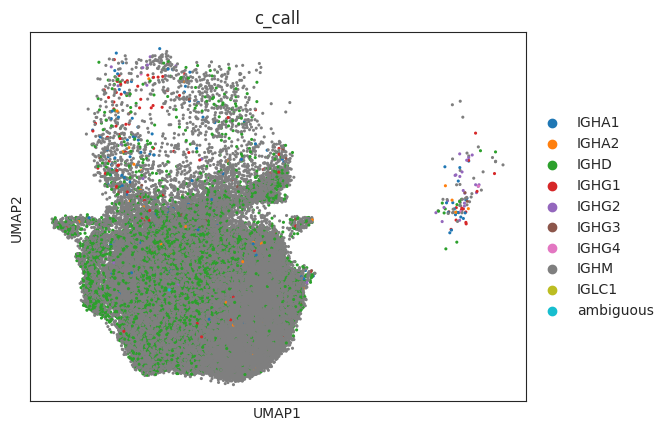

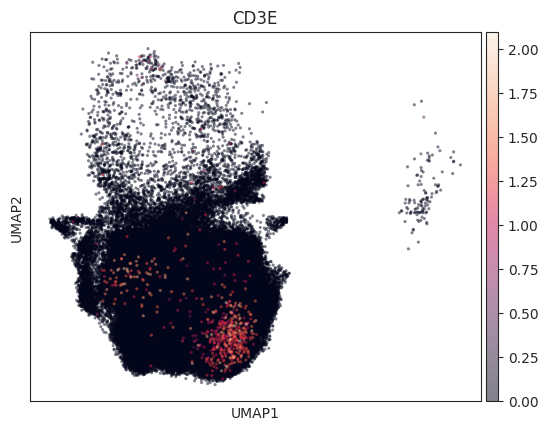

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


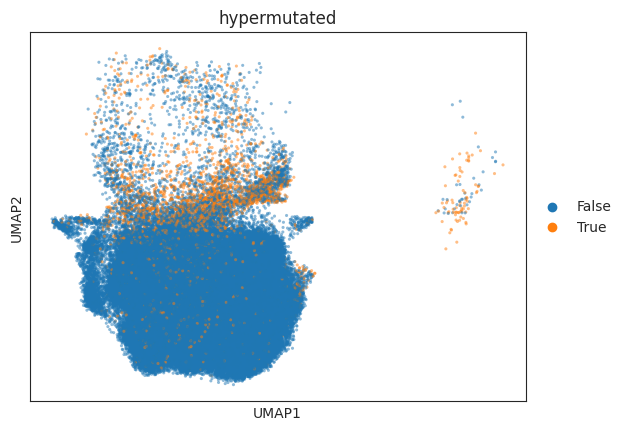

In [9]:

sc.pl.umap(adata, color = 'in_lin', size = 30, alpha = 0.5)
sc.pl.umap(adata, color = 'tissue', size = 20, alpha = 0.1)
sc.pl.umap(adata, color = 'leiden', size = 20, legend_loc="on data" )
sc.pl.umap(adata, color = 'S100A8', size = 20, alpha = 0.2)
sc.pl.umap(adata, color = 'c_call', size = 20)
sc.pl.umap(adata, color = 'CD3E', size = 20, alpha = 0.5)
sc.pl.umap(adata, color = 'hypermutated', size = 20, alpha = 0.5)

In [11]:
MD_only = adata[adata.obs.c_call.isin(['IGHM', "IGHD"])]

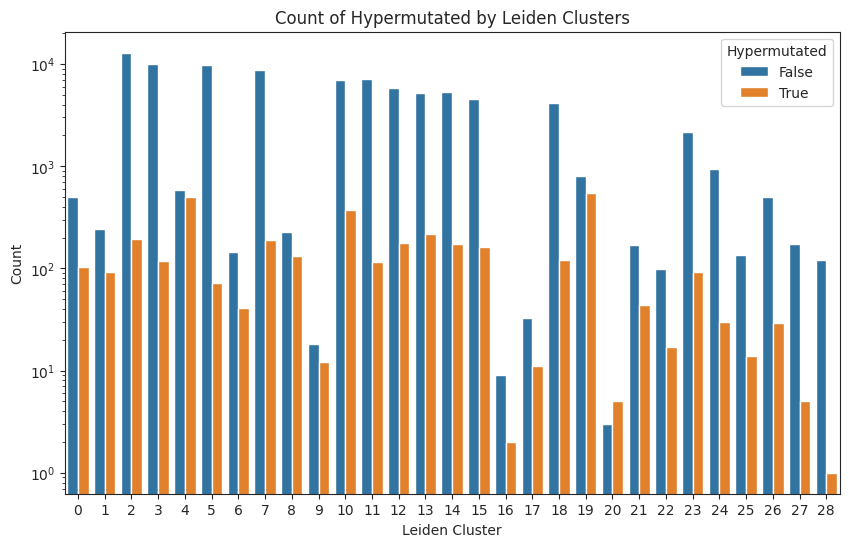

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the data by 'leiden' and count the 'hypermutated' values
grouped_data = MD_only.obs.groupby('leiden')['hypermutated'].value_counts().reset_index(name='count')

# Now, 'grouped_data' is a DataFrame with 'leiden', 'hypermutated', and 'count' columns

# Create a count plot using Seaborn
plt.figure(figsize=(10, 6))  # Set the figure size
sns.barplot(data=grouped_data, x='leiden', y = 'count', hue='hypermutated')  # Create the plot with 'leiden' and 'hypermutated'

# Additional plot customizations
plt.title('Count of Hypermutated by Leiden Clusters')  # Set title
plt.xlabel('Leiden Cluster')  # Set x-axis label
plt.ylabel('Count')  # Set y-axis label
plt.legend(title='Hypermutated')  # Set legend title
plt.yscale("log")
# Display the plot
plt.show()


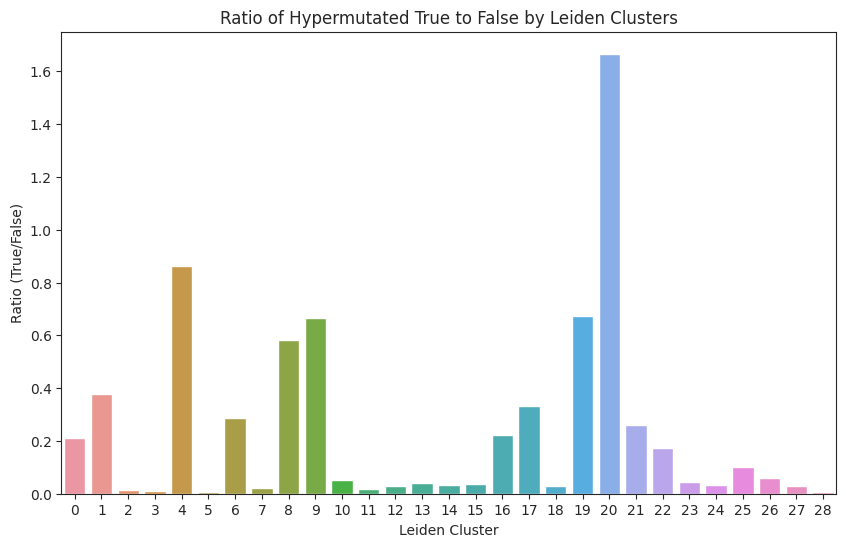

In [20]:
import pandas as pd

# Pivot the DataFrame to have 'leiden' as index and 'hypermutated' as columns
pivot_data = grouped_data.pivot(index='leiden', columns='hypermutated', values='count')

# Calculate the ratio of True to False for each 'leiden' cluster
pivot_data['ratio'] = pivot_data[True] / pivot_data[False]

# Reset index to make 'leiden' a column again
ratio_data = pivot_data.reset_index()

# Now 'ratio_data' has 'leiden' and 'ratio' columns, ready for plotting

# Create a bar plot using Seaborn to plot the ratios
plt.figure(figsize=(10, 6))  # Set the figure size
sns.barplot(data=ratio_data, x='leiden', y='ratio')  # Create the plot using 'barplot'

# Additional plot customizations
plt.title('Ratio of Hypermutated True to False by Leiden Clusters')  # Set title
plt.xlabel('Leiden Cluster')  # Set x-axis label
plt.ylabel('Ratio (True/False)')  # Set y-axis label

# Display the plot
plt.show()


In [22]:
sc.tl.rank_genes_groups(MD_only, groupby='leiden')


/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

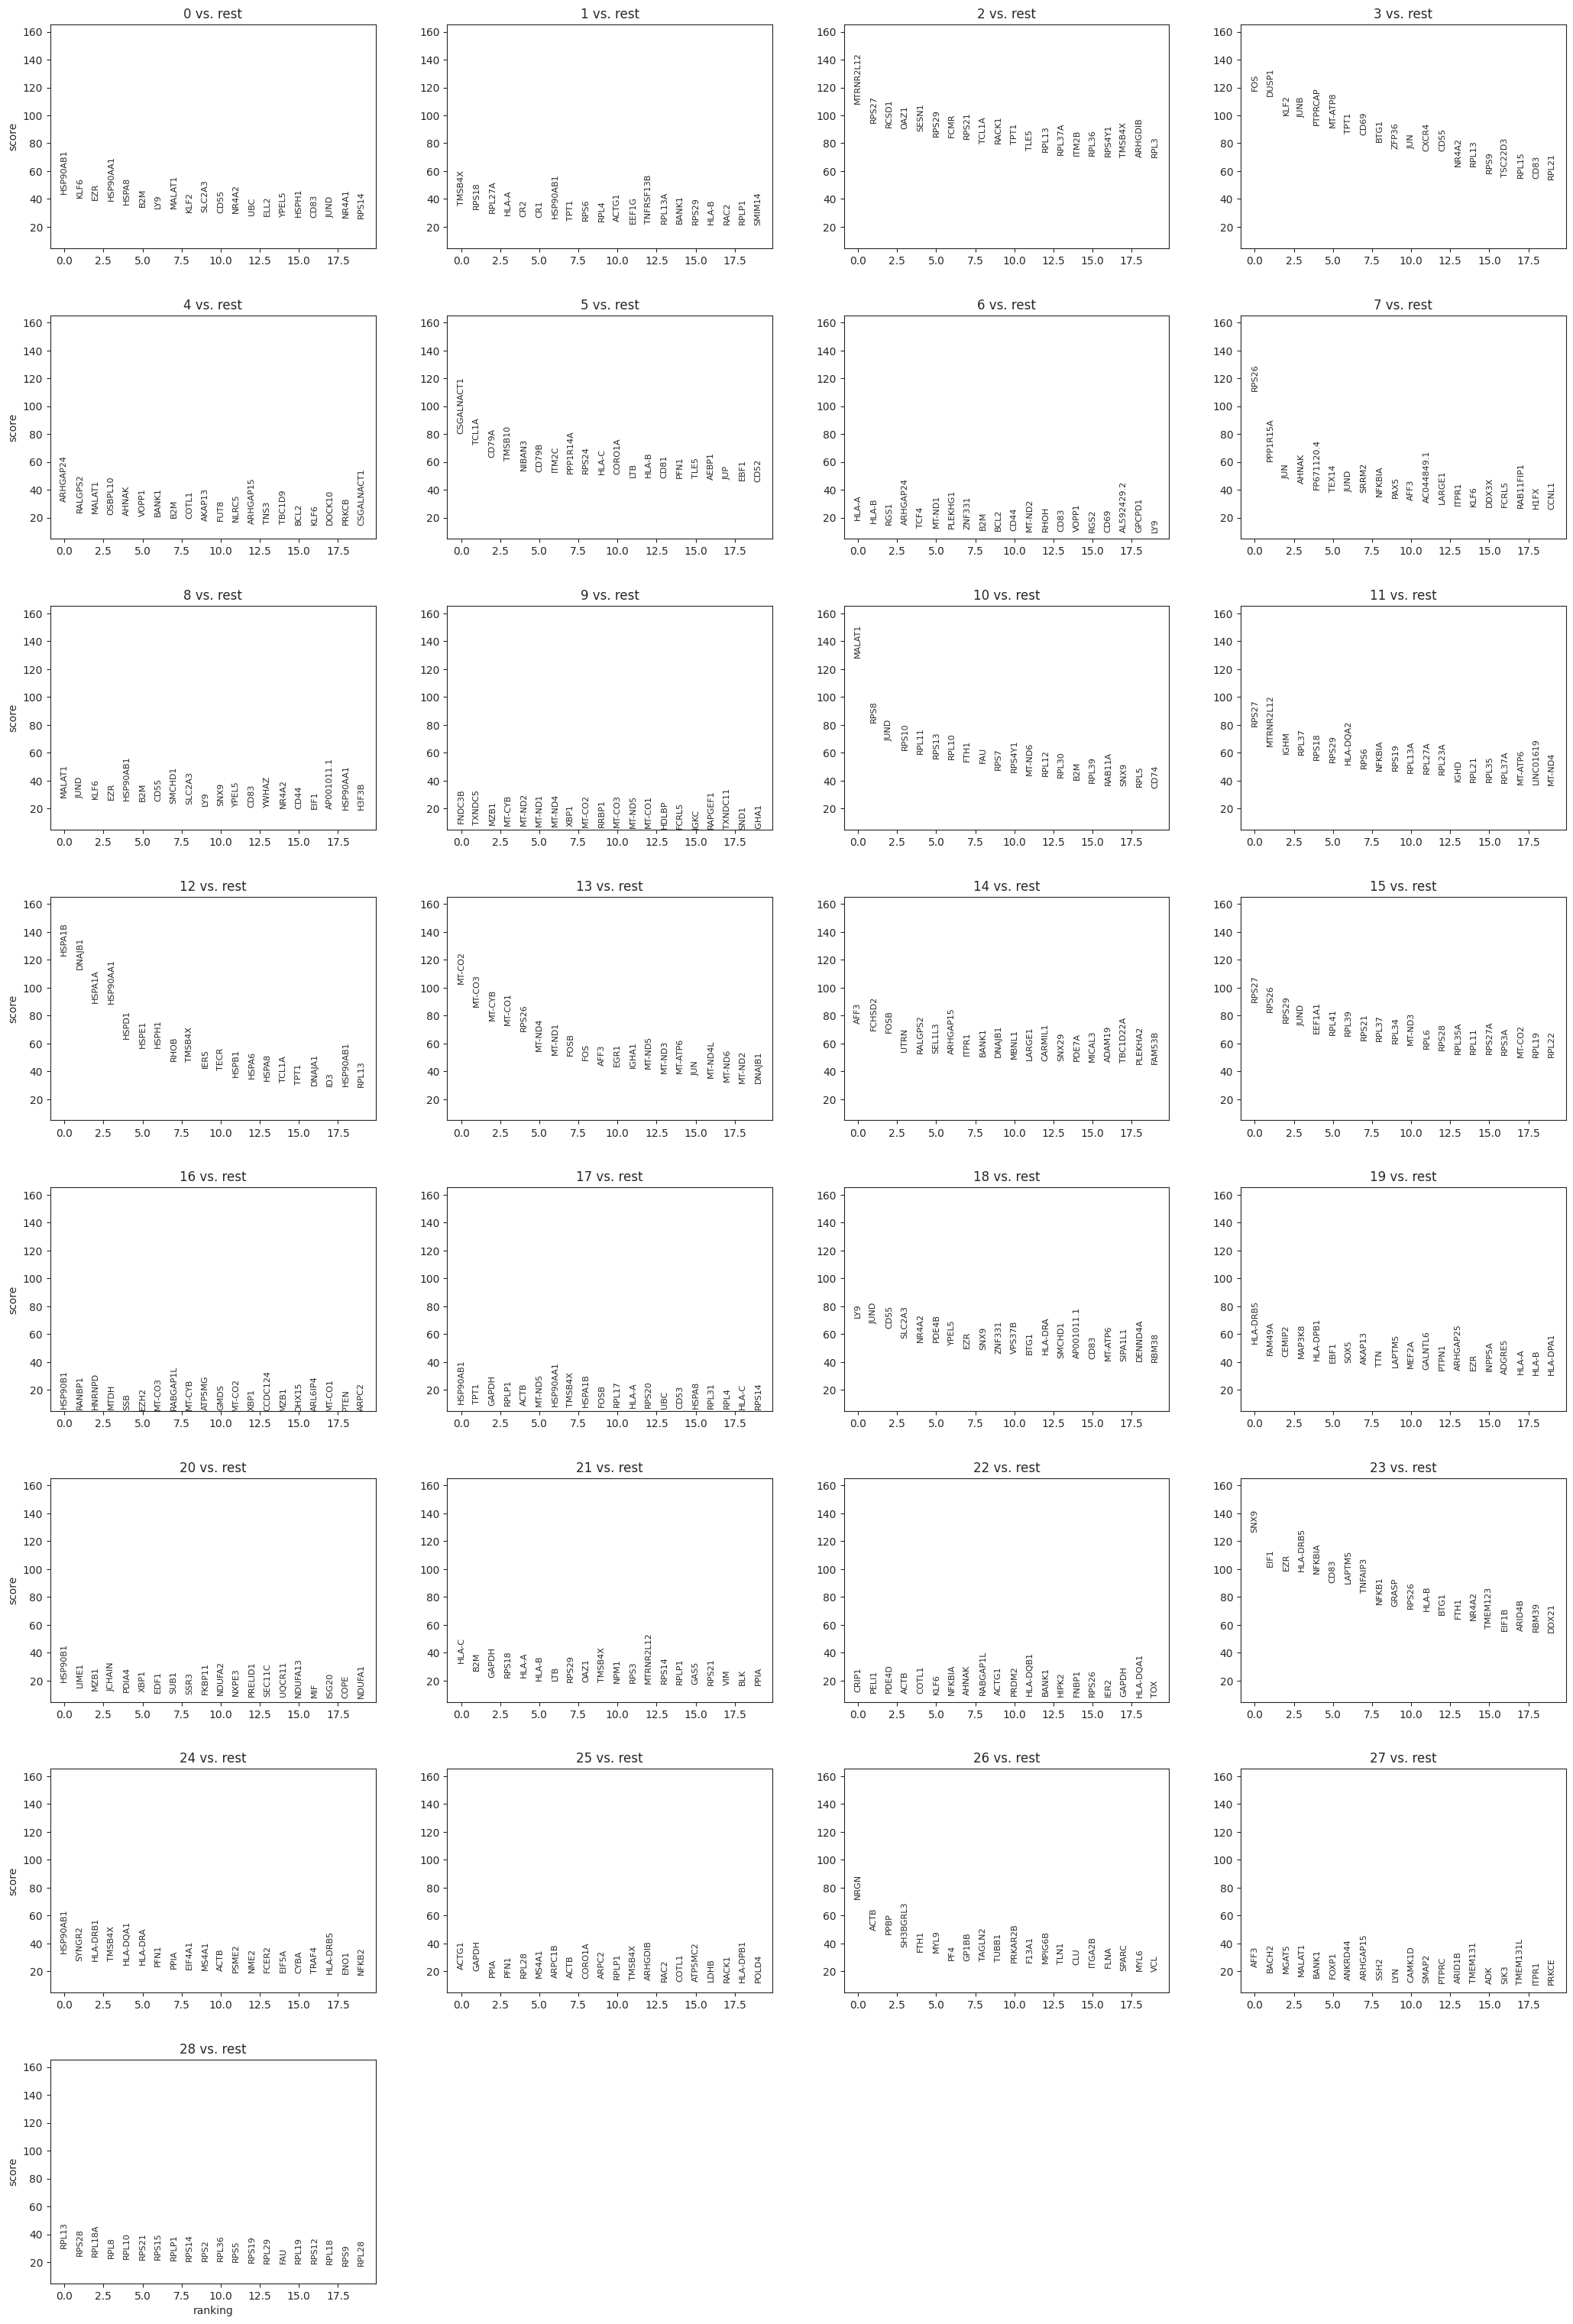

In [24]:
sc.pl.rank_genes_groups(MD_only)

In [ ]:
sc.pp.neighbors(MD_only, use_rep='X_scVI_all')

In [ ]:
sc.tl.umap(MD_only)

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


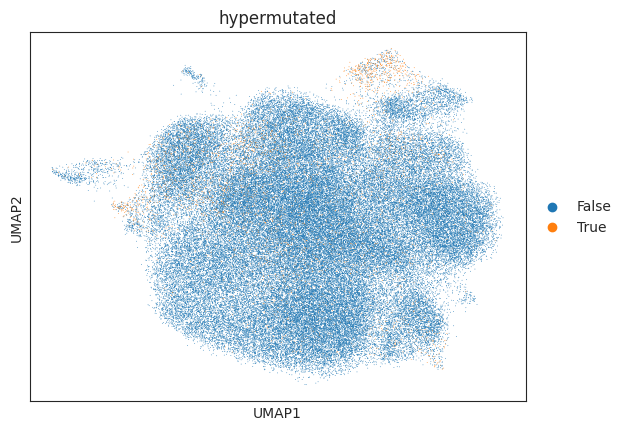

In [ ]:
sc.pl.umap(MD_only, color = 'hypermutated')

In [ ]:
sc.tl.leiden(MD_only)

In [ ]:
sc.tl.rank_genes_groups(MD_only, groupby='leiden')
sc.pl.rank_genes_groups(MD_only)

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


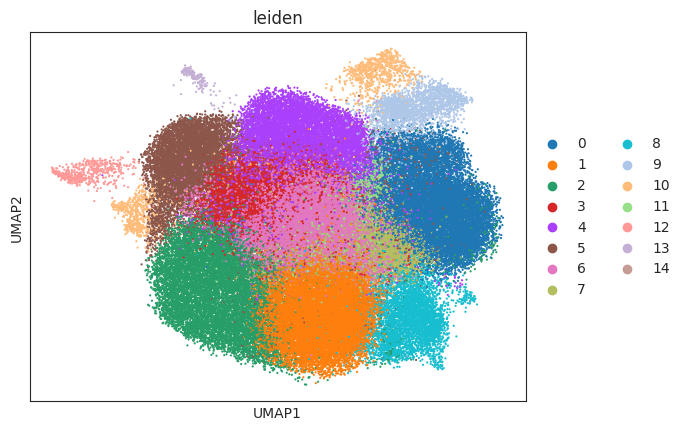

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


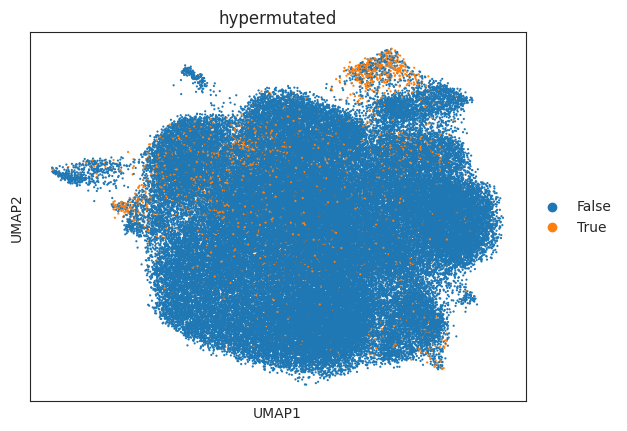

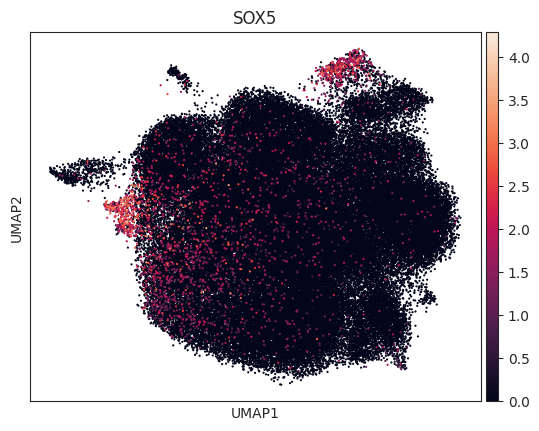

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


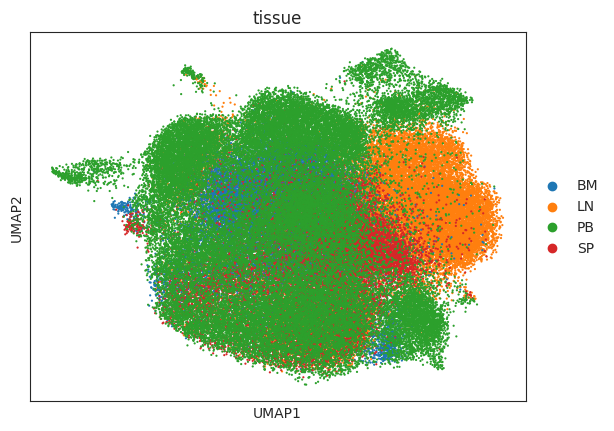

In [ ]:
sc.pl.umap(MD_only, color = 'leiden', size = 10)
sc.pl.umap(MD_only, color = 'hypermutated', size = 10)
sc.pl.umap(MD_only, color = 'SOX5', size = 10)
sc.pl.umap(MD_only, color = 'tissue', size = 10)

In [ ]:
MD_only.obs.groupby('leiden').hypermutated.value_counts()

leiden  hypermutated
0       False           13494
        True              364
1       False           13498
        True              291
2       False           11418
        True              147
3       False           10804
        True              567
4       False            8040
        True              350
5       False            6964
        True              487
6       False            7182
        True              209
7       False            6986
        True              263
8       False            4394
        True              163
9       False            2239
        True               58
10      False             921
        True              629
11      False            1150
        True               28
12      False             508
        True               29
13      False             174
        True                5
14      False               5
        True                0
Name: count, dtype: int64

In [ ]:
selector = MD_only.obs.groupby('leiden').size() > 1
selector = selector[selector].index

In [ ]:
MD_only = MD_only[MD_only.obs.leiden.isin(selector)]

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


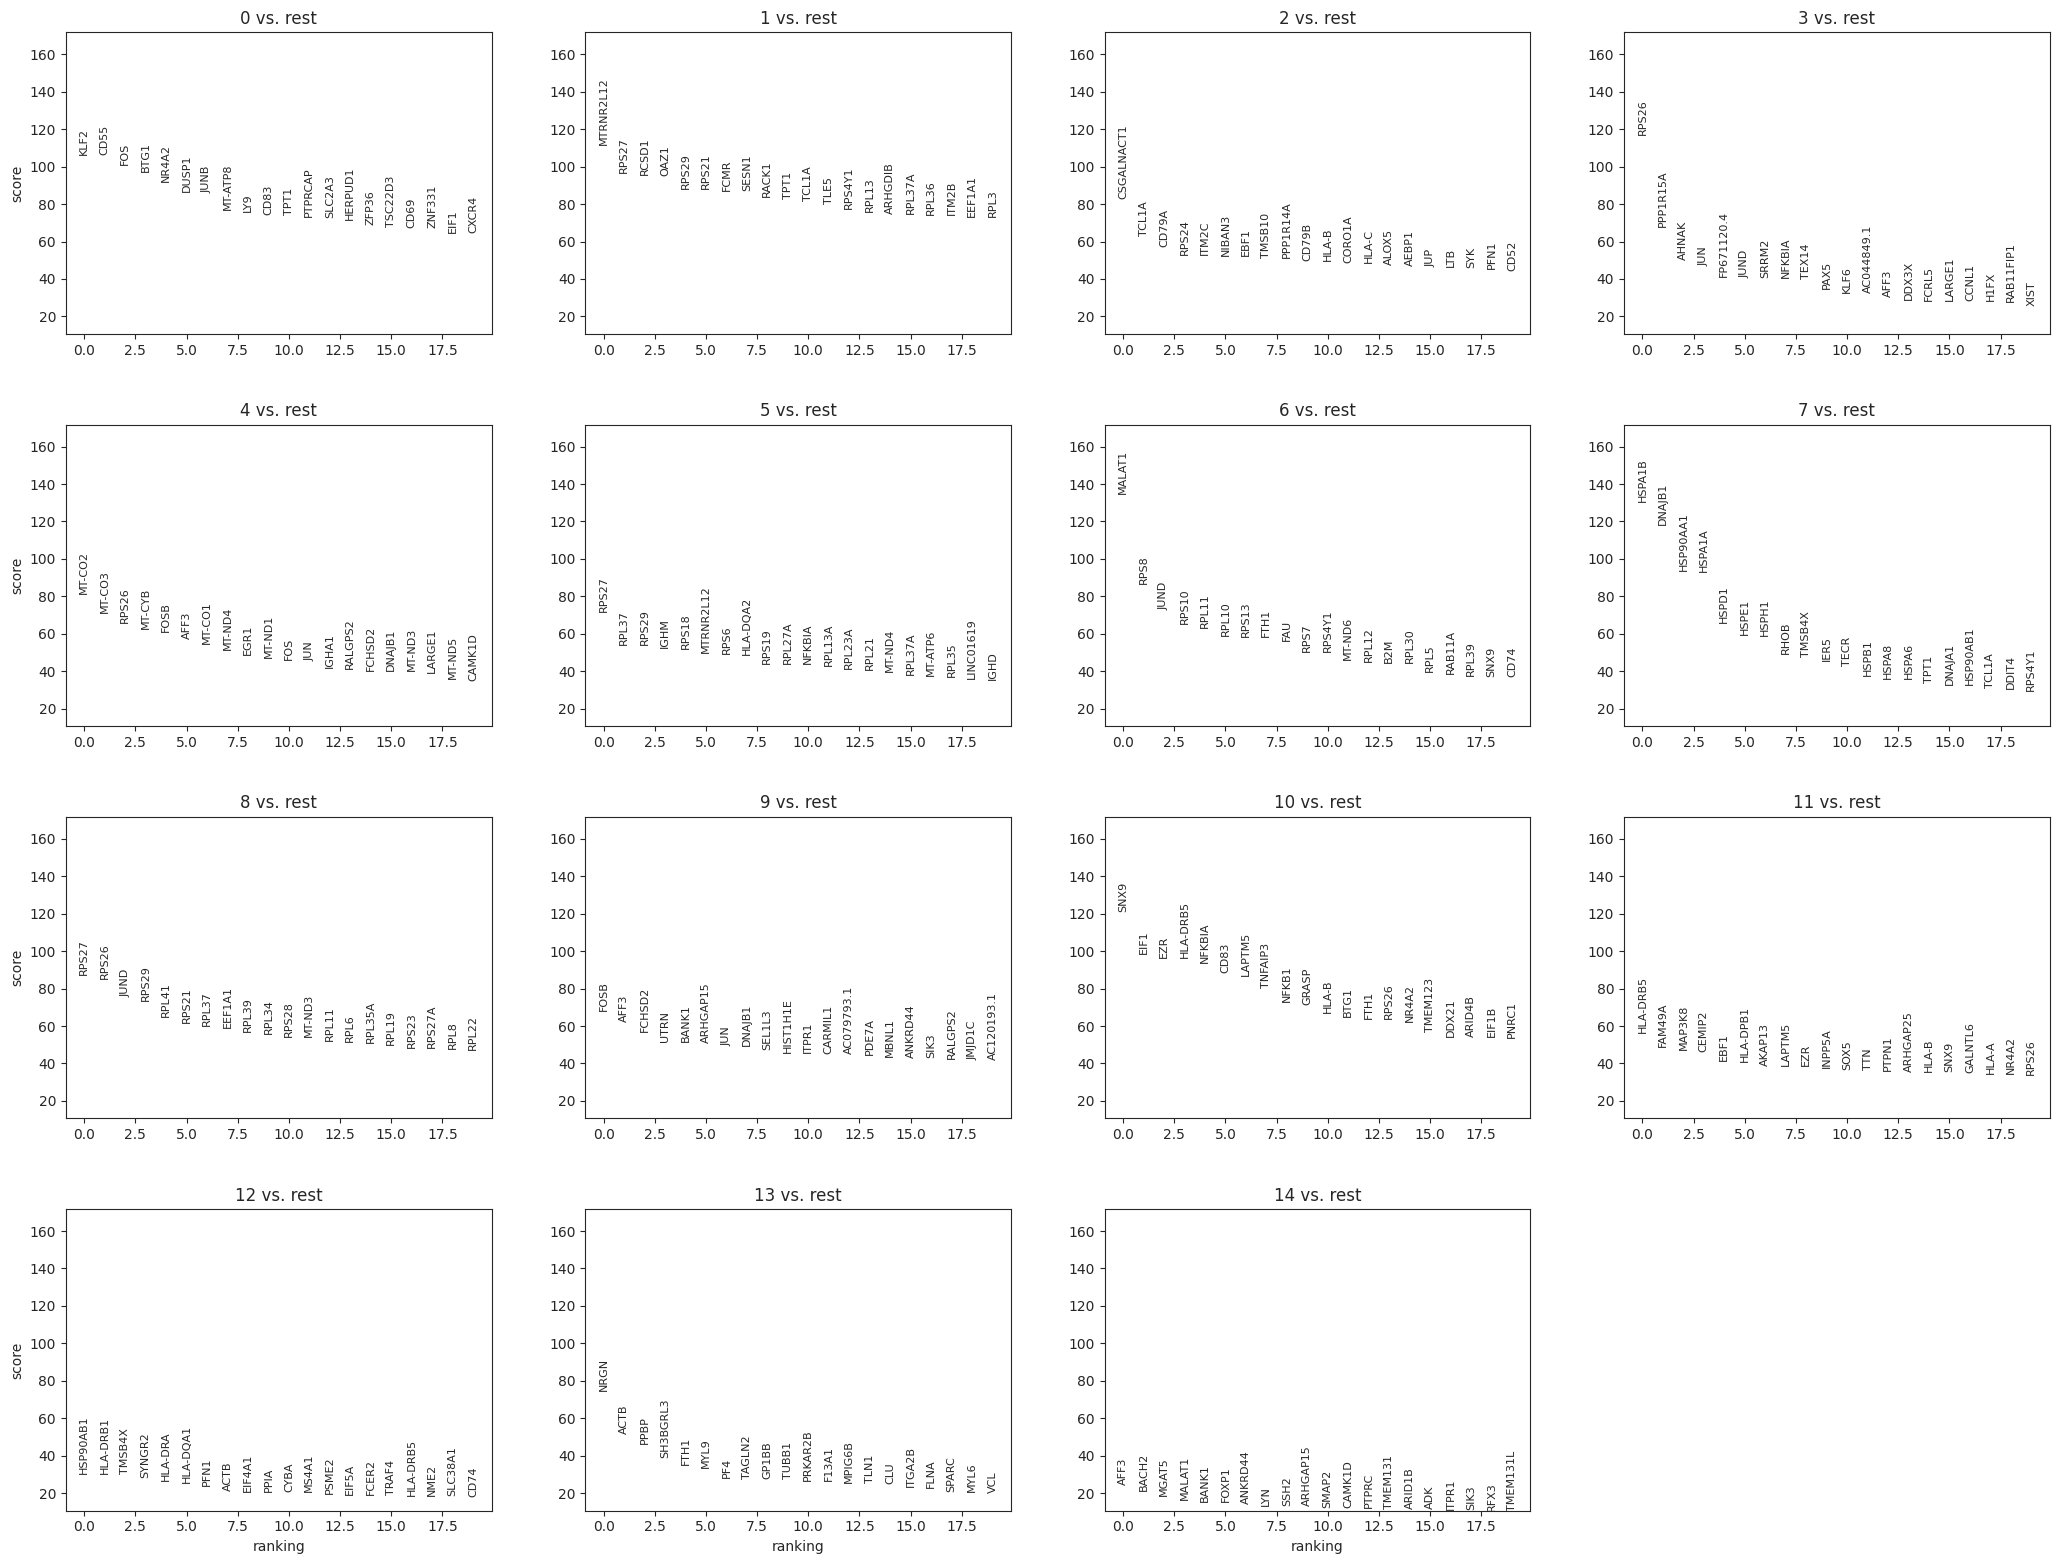

In [ ]:
sc.tl.rank_genes_groups(MD_only, groupby='leiden')
sc.pl.rank_genes_groups(MD_only)

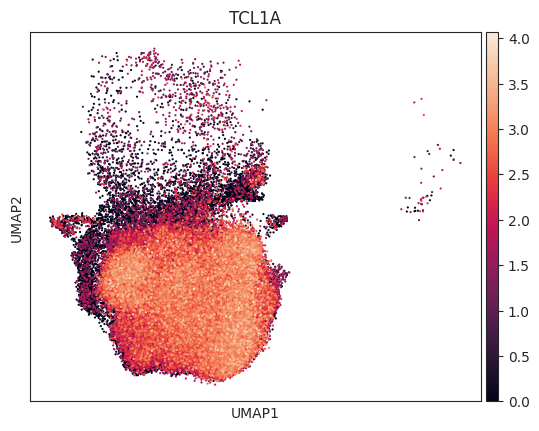

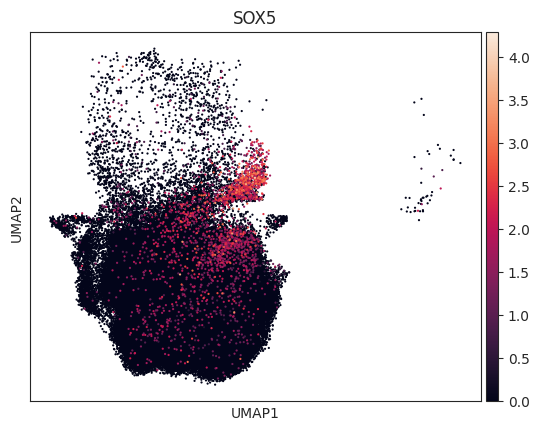

In [ ]:
sc.pl.umap(MD_only, color='TCL1A', size = 10)

sc.pl.umap(MD_only, color='SOX5', size = 10)

In [ ]:
sc.tl.rank_genes_groups(MD_only, groupby='leiden')
#sc.tl.rank_genes_groups(MD_only, groupby='hypermutated')

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/tools/_

/home/michaelswift/miniconda3/envs/scanpy_new/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


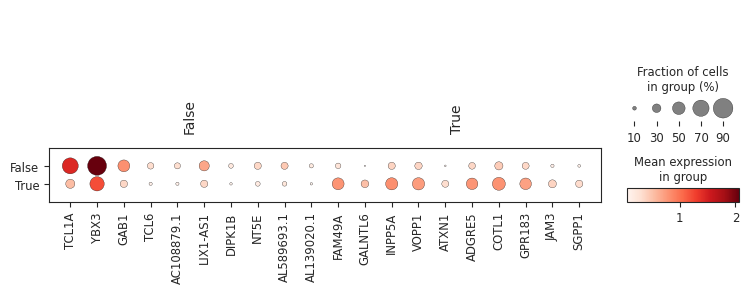

In [ ]:
sc.pl.rank_genes_groups_dotplot(MD_only, min_logfoldchange=1)

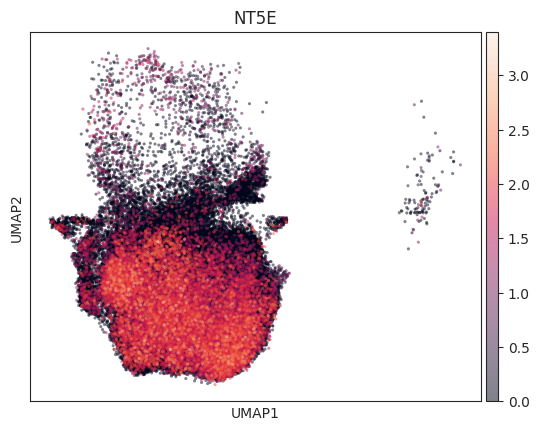

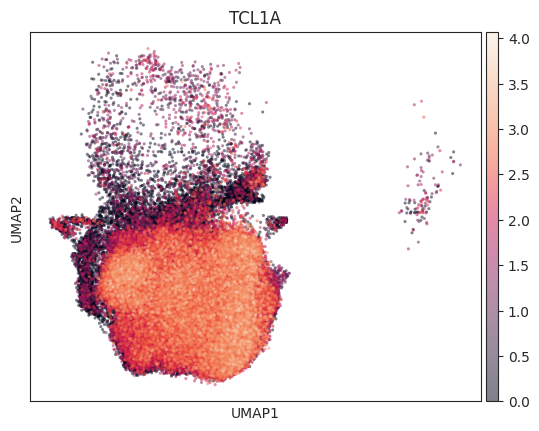

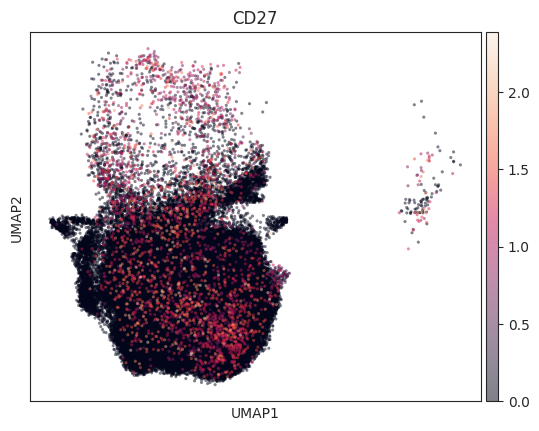

In [ ]:
sc.pl.umap(adata, color = 'NT5E', size = 20, alpha = 0.5)
sc.pl.umap(adata, color = 'TCL1A', size = 20, alpha = 0.5)
sc.pl.umap(adata, color = 'CD27', size = 20, alpha = 0.5)

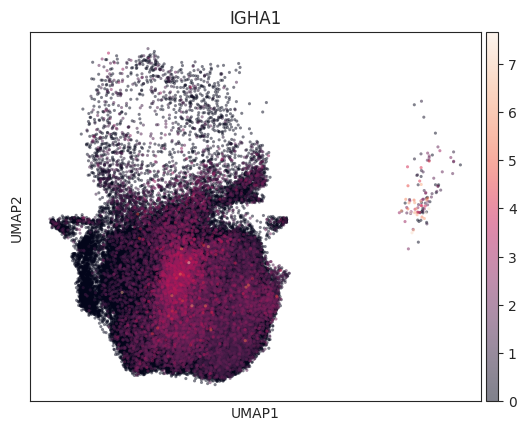

In [ ]:
sc.pl.umap(adata, color = "IGHA1", alpha = 0.5, size = 20)

### calculate umap and neighborhood graph

In [ ]:
# Resample each donor
# routine which asks what is the average distance between members of the "in lineage class" in PCA space

In [ ]:
from sklearn.metrics import pairwise_distances

In [ ]:
adata.obs.hypermutated

cb_suid
AAACCTGAGACGACGT_TBd1_frozen_MELN_HTa    False
AAACCTGCAACGATGG_TBd1_frozen_MELN_HTa    False
AAACCTGGTGCCTGGT_TBd1_frozen_MELN_HTa    False
AAACCTGTCACTCTTA_TBd1_frozen_MELN_HTa    False
AAACGGGAGCCCTAAT_TBd1_frozen_MELN_HTa    False
                                         ...  
TTTGTCAGTCGCTTTC_TBd6_fresh_PB           False
TTTGTCAGTCTGCAAT_TBd6_fresh_PB           False
TTTGTCAGTTTAGCTG_TBd6_fresh_PB           False
TTTGTCATCCGCATCT_TBd6_fresh_PB           False
TTTGTCATCGTTACGA_TBd6_fresh_PB           False
Name: hypermutated, Length: 92624, dtype: category
Categories (2, bool): [False, True]

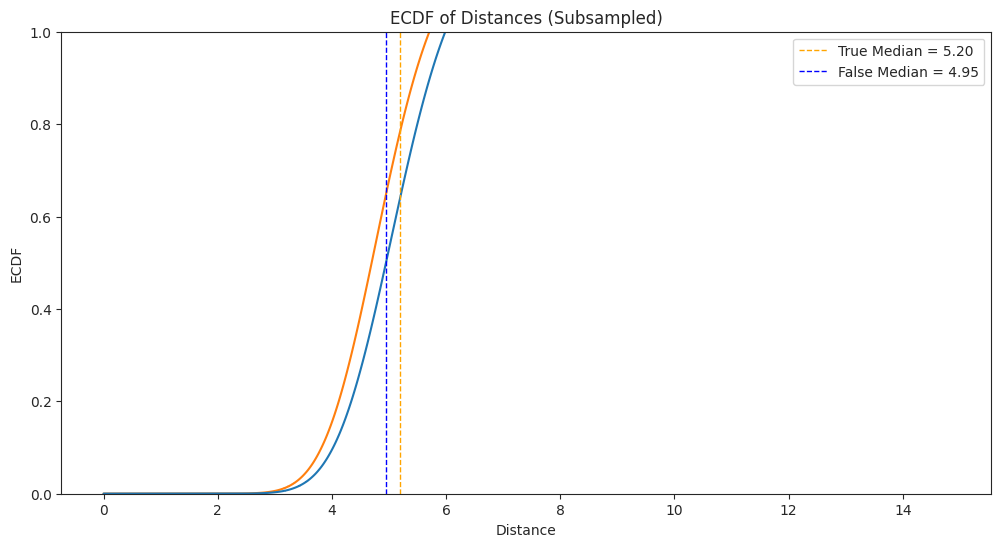

In [ ]:
# Extract the data matrix from adata.obsm
data_matrix = adata.obsm['X_scVI_all']

# Assuming `boolean_series` is your Series of "True" and "False" strings of length 95864
boolean_series = adata.obs.hypermutated
boolean_series = boolean_series.replace({"True": True, "False": False})

# Convert the Boolean Series to a NumPy array for efficient indexing
boolean_array = boolean_series.to_numpy()

# Find the indices of True and False in boolean_array
true_indices = np.where(boolean_array)[0]
false_indices = np.where(~boolean_array)[0]

# Randomly sample 10,000 indices from each set
n_samples = true_indices.shape[0]
true_sample_indices = np.random.choice(true_indices, n_samples, replace=False)
false_sample_indices = np.random.choice(false_indices, n_samples, replace=False)

# Calculate distances for the sampled indices
true_distances = pairwise_distances(data_matrix[true_sample_indices], metric='euclidean')
false_distances = pairwise_distances(data_matrix[false_sample_indices], metric='euclidean')

# Flatten the matrices and create a DataFrame for plotting
df = pd.DataFrame({
    'Distance': np.concatenate([true_distances.flatten(), false_distances.flatten()]),
    'Label': np.concatenate([np.repeat('True', n_samples * n_samples), np.repeat('False', n_samples * n_samples)])
})

# Calculate the medians for both sets of distances
true_median = np.mean(true_distances)
false_median = np.mean(false_distances)

# Create the ECDF plot using Seaborn
plt.figure(figsize=(12, 6))
sns.ecdfplot(data=df, x='Distance', hue='Label')

# Add vertical lines to indicate medians
#plt.axvline(true_median, color='orange', linestyle='dashed', linewidth=1, label=f'True Median = {true_median:.2f}')
#plt.axvline(false_median, color='blue', linestyle='dashed', linewidth=1, label=f'False Median = {false_median:.2f}')

plt.title('ECDF of Distances (Subsampled)')
plt.xlabel('Distance')
plt.ylabel('ECDF')
plt.legend()

plt.show()


In [ ]:
true_indices.shape

(629,)

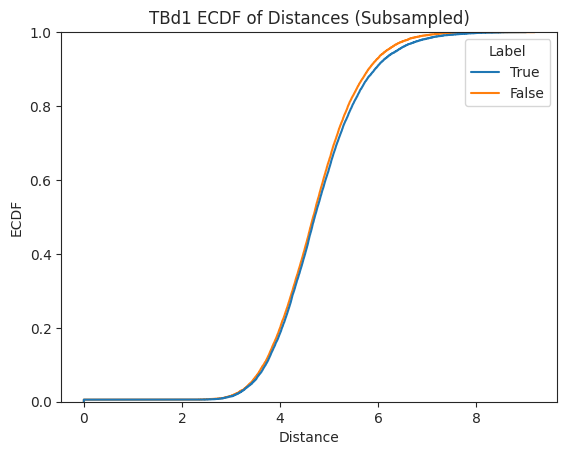

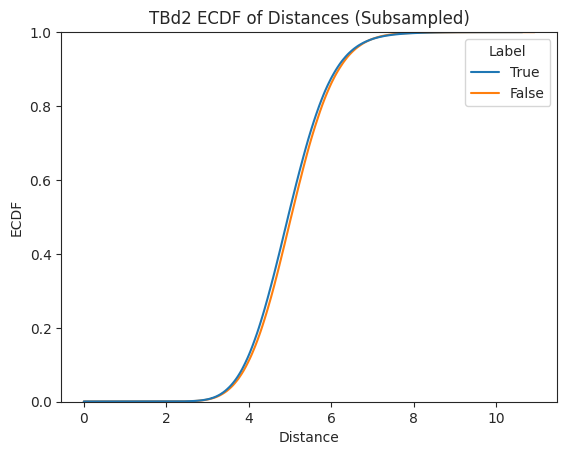

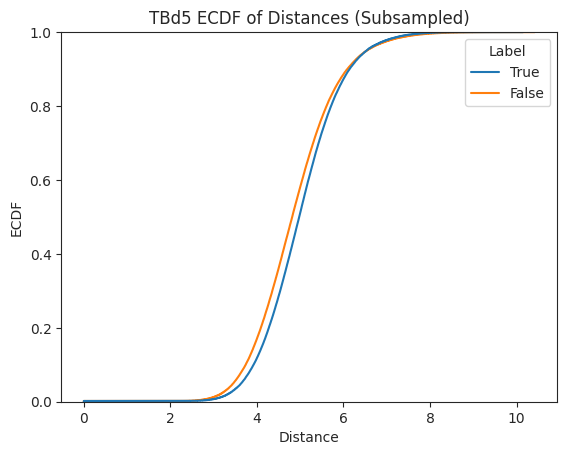

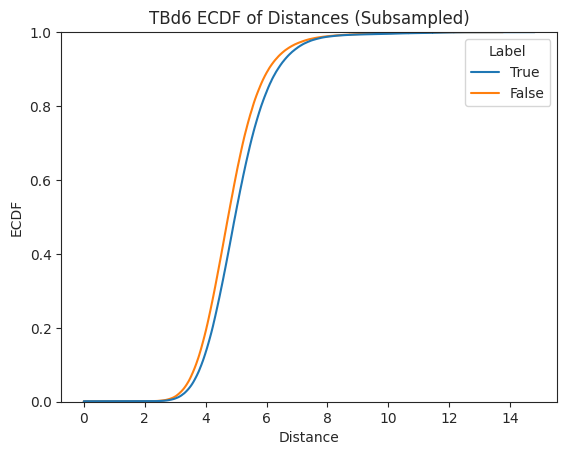

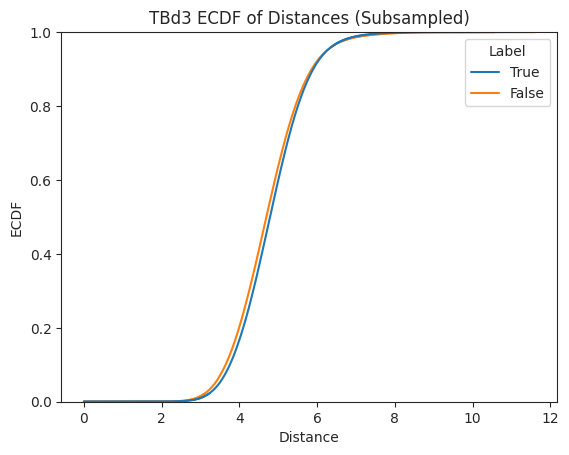

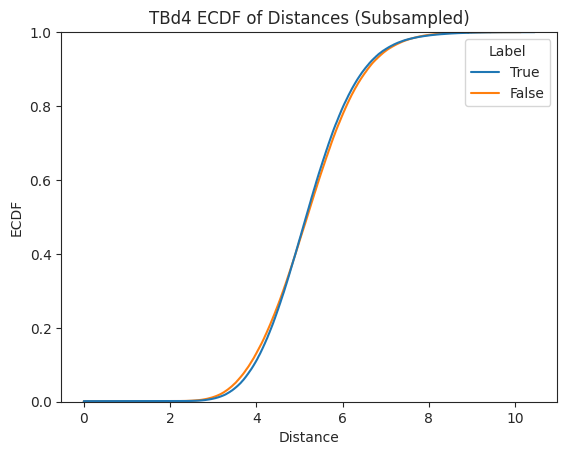

In [ ]:
# Extract the data matrix from adata.obsm
for donor in adata.obs.donor.unique():
    bydonor_adata = adata[adata.obs.donor == donor]


    data_matrix = bydonor_adata.obsm['X_scVI_all']

    # Assuming `boolean_series` is your Series of "True" and "False" strings of length 95864
    boolean_series = bydonor_adata.obs.hypermutated
    boolean_series = boolean_series.replace({"True": True, "False": False})

    # Convert the Boolean Series to a NumPy array for efficient indexing
    boolean_array = boolean_series.to_numpy()

    # Find the indices of True and False in boolean_array
    true_indices = np.where(boolean_array)[0]
    false_indices = np.where(~boolean_array)[0]

    # Randomly sample 10,000 indices from each set
    n_samples = true_indices.shape[0]
    true_sample_indices = np.random.choice(true_indices, n_samples, replace=False)
    false_sample_indices = np.random.choice(false_indices, n_samples, replace=False)

    # Calculate distances for the sampled indices
    true_distances = pairwise_distances(data_matrix[true_sample_indices], metric='euclidean')
    false_distances = pairwise_distances(data_matrix[false_sample_indices], metric='euclidean')

    # Flatten the matrices and create a DataFrame for plotting
    df = pd.DataFrame({
        'Distance': np.concatenate([true_distances.flatten(), false_distances.flatten()]),
        'Label': np.concatenate([np.repeat('True', n_samples * n_samples), np.repeat('False', n_samples * n_samples)])
    })

    # Calculate the medians for both sets of distances
    true_median = np.median(true_distances)
    false_median = np.median(false_distances)

    # Create the ECDF plot using Seaborn
    fig, ax = plt.subplots(1,1)
    sns.ecdfplot(data=df, x='Distance', hue='Label')

    # Add vertical lines to indicate medians
    #plt.axvline(true_median, color='orange', linestyle='dashed', linewidth=1, label=f'True Median = {true_median:.2f}')
    #plt.axvline(false_median, color='blue', linestyle='dashed', linewidth=1, label=f'False Median = {false_median:.2f}')

    ax.set_title(f'{donor} ECDF of Distances (Subsampled)')
    ax.set_xlabel('Distance')
    ax.set_ylabel('ECDF')


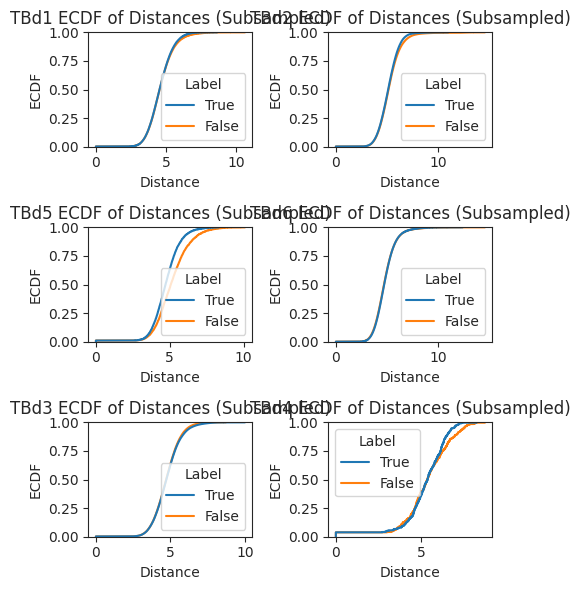

In [ ]:
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Get the unique donors
unique_donors = adata.obs.donor.unique()

# Create a subplot grid based on the number of unique donors
n_donors = len(unique_donors)
fig, axes = plt.subplots(int(np.ceil(n_donors / 2)), 2, figsize=(5, n_donors * 1))
axes = axes.flatten()  # Flatten the 2D array to 1D for easy indexing

# Loop through each unique donor to create subplots
for i, donor in enumerate(unique_donors):
    ax = axes[i]
    
    bydonor_adata = adata[adata.obs.donor == donor]
    data_matrix = bydonor_adata.obsm['X_scVI_all']

    boolean_series = bydonor_adata.obs.in_lin
    boolean_series = boolean_series.replace({"True": True, "False": False})

    boolean_array = boolean_series.to_numpy()

    true_indices = np.where(boolean_array)[0]
    false_indices = np.where(~boolean_array)[0]

    n_samples = min(true_indices.shape[0], false_indices.shape[0])
    true_sample_indices = np.random.choice(true_indices, n_samples, replace=False)
    false_sample_indices = np.random.choice(false_indices, n_samples, replace=False)

    true_distances = pairwise_distances(data_matrix[true_sample_indices], metric='euclidean')
    false_distances = pairwise_distances(data_matrix[false_sample_indices], metric='euclidean')

    df = pd.DataFrame({
        'Distance': np.concatenate([true_distances.flatten(), false_distances.flatten()]),
        'Label': np.concatenate([np.repeat('True', n_samples * n_samples), np.repeat('False', n_samples * n_samples)])
    })

    true_median = np.median(true_distances)
    false_median = np.median(false_distances)

    sns.ecdfplot(data=df, x='Distance', hue='Label', ax=ax)

    ax.set_title(f'{donor} ECDF of Distances (Subsampled)')
    ax.set_xlabel('Distance')
    ax.set_ylabel('ECDF')
    ax.legend
# Remove any unused subplots
for i in range(len(unique_donors), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [ ]:
true_distances

array([[0.       , 4.117044 , 4.9551845, 6.1548305, 4.535417 , 4.7530403,
        6.21032  , 6.4401116, 4.4531198, 5.9776525, 5.870942 , 4.795593 ,
        6.9176507, 5.319587 , 5.0795503, 3.608035 , 4.97186  , 6.9824314,
        6.239343 , 4.965523 , 5.064078 , 6.356661 , 4.835023 , 5.021911 ,
        6.3457193, 6.015689 ],
       [4.117044 , 0.       , 4.262799 , 6.2368727, 2.8865602, 4.2844315,
        6.0426917, 5.9513845, 5.0383   , 5.809367 , 5.5738945, 4.1070414,
        6.48338  , 5.3907247, 4.2502418, 4.15215  , 4.21026  , 6.3459673,
        5.204118 , 5.060923 , 4.7639875, 6.3568754, 4.844826 , 4.924348 ,
        6.166022 , 4.6561923],
       [4.9551845, 4.262799 , 0.       , 6.2356563, 4.362299 , 5.9520283,
        5.346428 , 5.3972306, 4.712509 , 4.549614 , 5.1907907, 4.9093156,
        6.1786575, 5.220068 , 5.51427  , 5.441507 , 5.2066574, 4.1776986,
        3.455166 , 5.841214 , 5.0220366, 4.37461  , 3.3484473, 4.543068 ,
        4.200968 , 5.07111  ],
       [6.1548305, 

In [ ]:
df

Distance  Label
0     0.000000   True
1     4.117044   True
2     4.955184   True
3     6.154830   True
4     4.535417   True
...        ...    ...
1347  3.797136  False
1348  4.864995  False
1349  4.145799  False
1350  5.081624  False
1351  0.000000  False

[1352 rows x 2 columns]

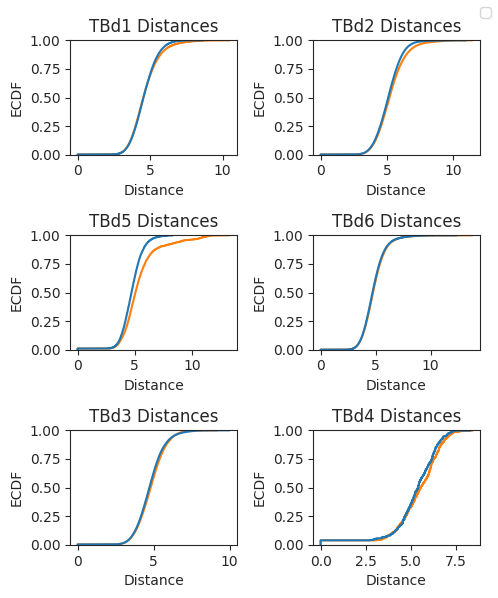

In [ ]:
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Get the unique donors
unique_donors = adata.obs.donor.unique()

# Create a subplot grid based on the number of unique donors
n_donors = len(unique_donors)
fig, axes = plt.subplots(int(np.ceil(n_donors / 2)), 2, figsize=(5, n_donors))
axes = axes.flatten()  # Flatten the 2D array to 1D for easy indexing

# Initialize variables to hold legend information
handles, labels = None, None

# Loop through each unique donor to create subplots
for i, donor in enumerate(unique_donors):
    ax = axes[i]
    
    bydonor_adata = adata[adata.obs.donor == donor]
    data_matrix = bydonor_adata.obsm['X_scVI_all']

    boolean_series = bydonor_adata.obs.in_lin
    boolean_series = boolean_series.replace({"True": True, "False": False})

    boolean_array = boolean_series.to_numpy()

    true_indices = np.where(boolean_array)[0]
    false_indices = np.where(~boolean_array)[0]

    n_samples = min(true_indices.shape[0], false_indices.shape[0])
    true_sample_indices = np.random.choice(true_indices, n_samples, replace=False)
    false_sample_indices = np.random.choice(false_indices, n_samples, replace=False)

    true_distances = pairwise_distances(data_matrix[true_sample_indices], metric='euclidean')
    false_distances = pairwise_distances(data_matrix[false_sample_indices], metric='euclidean')

    df = pd.DataFrame({
        'Distance': np.concatenate([true_distances.flatten(), false_distances.flatten()]),
        'Label': np.concatenate([np.repeat('True', n_samples * n_samples), np.repeat('False', n_samples * n_samples)])
    })

    sns.ecdfplot(data=df, x='Distance', hue='Label', ax=ax, legend=False)

    ax.set_title(f'{donor} Distances')
    ax.set_xlabel('Distance')
    ax.set_ylabel('ECDF')

    # Capture legend information
    handles, labels = ax.get_legend_handles_labels()

# Remove any unused subplots
for i in range(len(unique_donors), len(axes)):
    fig.delaxes(axes[i])

# Add a single global legend
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()


import scipy.sparse as sp
boolean_series = adata.obs.in_lin.astype(bool)
# Assuming `distance_matrix` is your 95864x95864 sparse matrix
# and `boolean_series` is your Series of "True" and "False" strings of length 95864
distance_matrix = adata.obsp['distances']

boolean_series = adata.obs.in_lin
boolean_series = boolean_series.replace({"True": True, "False": False})

# Convert the Boolean Series to a NumPy array for efficient indexing
boolean_array = boolean_series.to_numpy()

# Find the row and column indices as well as the data from the sparse matrix
rows, cols, data = sp.find(distance_matrix)

# Filter distances based on the boolean_array
true_distances = data[boolean_array[rows]]
false_distances = data[~boolean_array[rows]]

# Calculate the medians for both sets of distances
true_median = np.median(true_distances)
false_median = np.median(false_distances)

# Plot histograms on the same axis
plt.figure(figsize=(12, 6))

plt.hist(true_distances, bins=50, alpha=0.5, color='g', label='True')
plt.hist(false_distances, bins=50, alpha=0.5, color='r', label='False')

# Add vertical lines to indicate medians
plt.axvline(true_median, color='g', linestyle='dashed', linewidth=1, label=f'True Median = {true_median:.2f}')
plt.axvline(false_median, color='r', linestyle='dashed', linewidth=1, label=f'False Median = {false_median:.2f}')

plt.title('Distribution of Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()

plt.show()


from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import pandas as pd
import numpy as np

# Extract the data matrix from adata.obsm
data_matrix = adata.obsm['X_scVI_all']

# Calculate the Euclidean distance matrix
distance_matrix = pairwise_distances(data_matrix, metric='euclidean')

# Convert to sparse matrix to save memory if needed
distance_matrix = sp.csr_matrix(distance_matrix)

# Assuming `boolean_series` is your Series of "True" and "False" strings of length 95864
boolean_series = adata.obs.in_lin
boolean_series = boolean_series.replace({"True": True, "False": False})

# Convert the Boolean Series to a NumPy array for efficient indexing
boolean_array = boolean_series.to_numpy()

# Find the row and column indices as well as the data from the sparse matrix
rows, cols, data = sp.find(distance_matrix)

# Filter distances based on the boolean_array
true_distances = data[boolean_array[rows]]
false_distances = data[~boolean_array[rows]]

# Create a DataFrame to hold the distances and their corresponding labels
df = pd.DataFrame({
    'Distance': np.concatenate([true_distances, false_distances]),
    'Label': np.concatenate([np.repeat('True', len(true_distances)), np.repeat('False', len(false_distances))])
})

# Calculate the medians for both sets of distances
true_median = np.median(true_distances)
false_median = np.median(false_distances)

# Create the ECDF plot using Seaborn
plt.figure(figsize=(12, 6))
sns.ecdfplot(data=df, x='Distance', hue='Label')

# Add vertical lines to indicate medians
plt.axvline(true_median, color='g', linestyle='dashed', linewidth=1, label=f'True Median = {true_median:.2f}')
plt.axvline(false_median, color='r', linestyle='dashed', linewidth=1, label=f'False Median = {false_median:.2f}')

plt.title('ECDF of Distances')
plt.xlabel('Distance')
plt.ylabel('ECDF')
plt.legend()

plt.show()


# Donor resampling 

n = adata.obs.groupby("donor").size().min()
resampled_ad = adata[adata.obs.groupby('donor').sample(n = n, replace=False).index]
sc.tl.rank_genes_groups(resampled_ad, groupby='in_lin')
sc.pl.umap(resampled_ad, color = 'in_lin', size = 20)
sc.pl.rank_genes_groups(resampled_ad)
resampled_ad.obs.groupby("tissue").in_lin.value_counts(normalize = True)
sc.pl.rank_genes_groups_dotplot(resampled_ad, min_logfoldchange=1)
sc.pl.rank_genes_groups_dotplot(resampled_ad)

sc.pl.violin(adata, keys=['UTY', 'MZB1', 'CD27', "JCHAIN", "DDX3Y", "FCMR","S1PR4"], groupby='in_lin', stripplot=False)

sc.pl.stacked_violin(adata, var_names=['UTY', 'MZB1', 'CD27', "JCHAIN", "DDX3Y", "FCMR"], groupby='in_lin', stripplot=False)



sc.pl.stacked_violin(adata, var_names=['UTY', 'MZB1', 'CD27', "JCHAIN", "DDX3Y", "FCMR", "S1PR4"], groupby='in_lin', stripplot=False)
leiden_colors = dict(zip(adata.uns['leiden_colors'], adata.obs.leiden.unique().sort_values()))

celltypist_colors = dict(zip(adata.obs.celltypist.unique().sort_values(), adata.uns['celltypist_colors']))
sc.pl.umap(adata, color = 'hypermutated', size = 10, alpha = 0.5)
sc.pl.umap(adata, color = 'celltypist', size = 10, alpha = 0.7)

sc.pl.umap(adata, color = 'SOX5', size = 10, alpha = 0.5)

sc.pl.umap(adata, color = 'EZR', size = 10, alpha = 0.5)
sc.pl.umap(adata, color = 'CD55', size = 10, alpha = 0.5)

sc.pl.umap(adata, color = 'SEC63', size = 10, alpha = 0.5)

sc.pl.umap(adata, color = 'tissue', size = 10, alpha = 0.5)
adata.obs.groupby('leiden').hypermutated.value_counts(normalize = True)

adata.obs.groupby('leiden').hypermutated.value_counts(normalize = False)
ad = adata[~adata.obs.celltypist.str.contains("Age")]
sc.tl.rank_genes_groups(ad, groupby='hypermutated')
sc.pl.rank_genes_groups(ad)
ad
sns.ecdfplot(data = adata.obs, x = 'v_mismatch', hue = 'leiden', complementary=True)